In [320]:
import numpy as np
import pandas as pd
from numba import njit

Hello

# Functions

In [321]:
#Normalisation & standardization functions
min_max = lambda serie: (serie - np.min(serie)) / (np.max(serie) - np.min(serie))
mean_normalization = lambda serie: (serie - np.mean(serie)) / (np.max(serie) - np.min(serie))
standardization = lambda serie: (serie - np.mean(serie)) / np.std(serie)

def sigmoid(x):
    big_out = np.where(x > 100, 100, x)
    small_out = np.where(big_out < -100, -100, big_out)
    return 1 / (1+ np.exp(-small_out))

dSigmoid = lambda x: x * (1-sigmoid(x))

#Loss functions
binary_crossentropy = lambda y_real, y_pred: -np.mean(y_real * np.log(y_pred + 1e-10) + (1-y_real) * np.log(1-y_pred + 1e-10))

In [322]:
df = pd.read_csv('Train.csv')
df = df.dropna(axis=1).drop(['ID','country','population'],axis=1)

In [323]:
df2 = min_max(mean_normalization(df))

In [324]:
features = df2.loc[:,'Q1':'Q25']
target = df2['target']

X = features.values.T
Y = target.values

In [325]:
len(X)

16

In [326]:
split = 0.8
size = X.shape[1]

X_test = X[:,int(size*split):]
X = X[:,:int(size*split)]

Y_test = Y[int(size*split):]
Y = Y[:int(size*split)]

In [327]:
X.shape, X_test.shape

((16, 83893), (16, 20974))

# Multi-layered Model
<img src='net.png' width='500px'>

# Modelling

In [328]:
def initiate_model(X, Y, learning_rate=0.001, hidden_layers=[10,10]):
    
    n_features, n_samples = X.shape
    layers = [n_features, *hidden_layers, 1]
    
    model = {'learning_rate':learning_rate, 'layers':layers, 'W':{}, 'B':{}}

    for layer, nodes in enumerate(layers):
        
        #First layer doesn't have weights & biases
        if layer == 0:
            pass 
        else:
            model['W'][layer] = np.random.randn(layers[layer], layers[layer-1]) / np.sqrt(layers[layer-1])
            model['B'][layer] = np.zeros((layers[layer], 1))
            
    model['Z'], model['A'] = {}, {0:X}

    model['dLoss'] = {}
    model['dLoss']['Z'], model['dLoss']['A'], model['dLoss']['W'], model['dLoss']['B'],= {}, {}, {}, {}
            
    return model

In [329]:
#Calculating predictions with current weights and biases
def forwarding(model):
    
    layers = model['layers']
    
    for layer, nodes in enumerate(layers):
    
        #skip input layer because it doesn't need calculations
        if layer == 0:
            pass 
        
        else:
            
            # Mulitply output of last layer by weights (of current layer) & adding bias
            model['Z'][layer] = (model['W'][layer]).dot(model['A'][layer-1]) + model['B'][layer]
            
            #Transforming value using activation function to 0 to 1 range (Last A is the y_pred)
            model['A'][layer] = sigmoid(model['Z'][layer])
    
    return model

In [330]:
def backwarding(model):
    
    layers = model['layers']
    learning_rate = model['learning_rate']
    
    #Derivative of loss funtcion
    dLoss_Y_pred = model['dLoss']['A'][len(layers)-1] = (-Y / (y_pred+0.00001)) - ((1-Y)/(1-y_pred + 0.00001))
    
    #Start at last layer and update all weights and biases backwards
    for layer in range(len(layers)-1,0,-1):
        
        #Prevent muliplication overflow
        model['dLoss']['Z'][layer] = np.where(model['dLoss']['A'][layer] > 1000, 1000, model['dLoss']['A'][layer]) * np.where(dSigmoid(model['A'][layer]) > 1000, 1000, dSigmoid(model['A'][layer])) #Should be Z
        model['dLoss']['A'][layer-1] = np.dot(model['W'][layer].T, model['dLoss']['Z'][layer])
        model['dLoss']['W'][layer] =  1 / model['A'][layer-1].shape[1] * np.dot(model['dLoss']['Z'][layer], model['A'][layer-1].T)
        model['dLoss']['B'][layer] =  1 / model['A'][layer-1].shape[1] * np.dot(model['dLoss']['Z'][layer], np.ones([model['dLoss']['Z'][layer].shape[1], 1]))
        
        model['W'][layer] -= learning_rate * model['dLoss']['W'][layer]
        model['B'][layer] -= learning_rate * model['dLoss']['B'][layer]
        
    return model

In [331]:
#model['layers']

[16, 16, 16, 1]

In [337]:
last = 1
logger = 1
longer = []
model = initiate_model(X,Y,hidden_layers=[16,16],learning_rate=0.01)
for _ in range(1000):
    last = loss
    model = forwarding(model)
    y_pred = model['A'][len(model['A'])-1]  
    model = backwarding(model)
    loss = binary_crossentropy(model['A'][len(model['A'])-1], Y)
    longer.append(loss)
    
    if last - loss < 0.005:
        break
    print(loss)

11.623980733146714
11.604680440667423
11.585264844988965
11.565734788184967
11.546091131842445
11.526334756599375
11.506466561662378
11.486487464304354
11.466398399342166
11.44620031859428
11.425894190318285
11.405480998628342
11.3849617428924
11.364337437109153
11.343609109264605
11.32277780066815
11.30184456526799
11.280810468945727
11.259676588789892
11.23844401234819
11.217113836858116
11.195687168455636
11.174165121361469
11.152548817044584
11.130839383362297
11.109037953676372
11.087145665944512
11.065163661786285
11.043093085522804
11.020935083188972
10.998690801517329
10.976361386892158
10.953947984272512
10.93145173608264
10.908873781068054
10.88621525311546
10.863477280034397
10.840660982298457
10.817767471743512
10.794797850220332
10.77175320819878
10.748634623320346
10.725443158895828
10.702179862344567
10.67884576357158
10.655441873278761
10.631969181206214
10.608428654299875
10.584821234801664
10.561147838258785
10.53740935144934
10.513606630222503
10.48974049725284
10.46

<AxesSubplot:>

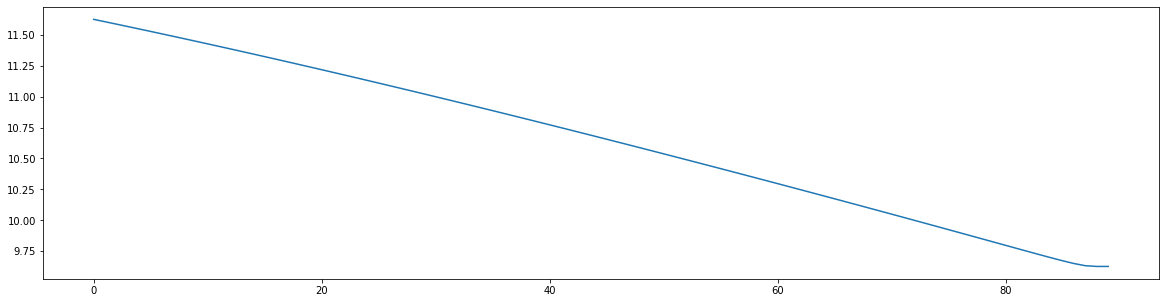

In [338]:
pd.Series(longer).plot(figsize=(20,5))

# Evaluating

In [343]:
model['A'][0] = X_test
model = forwarding(model)
predictions = model['A'][3]
print(round((np.where(predictions > 0.5, 1, 0) == Y_test).mean(),4))

0.5814
